In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')
os.listdir()

['.gitignore',
 'academic_creds.json',
 'credentials.json',
 'pyproject.toml',
 'poetry.lock',
 'README.md',
 '.venv',
 '.git',
 'data',
 'src',
 '.vscode']

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.1 MB 11.6 MB/s 
     |████████████████████████████████| 3.3 MB 29.2 MB/s 
     |████████████████████████████████| 1.2 MB 34.4 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=631411557807bfb47221fa9b2344476fc9e6e3d4ca808cae2b8f03531e82ac4c
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 3.0 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [153]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN

In [154]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
#sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)
sub = df.groupby(df.created_at.dt.to_period("M")).head(100)
df = sub

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [155]:
len(df)

1900

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

entities = list(df['entities'].values)
hashtags = list()
for e in entities:
    try:
        for tag in e['hashtags']:
            hashtags.append(tag['tag'])
    except:
        continue

Counter(hashtags).most_common(10)

[('dkpol', 1850),
 ('dkmedier', 339),
 ('dkgreen', 112),
 ('dkbiz', 54),
 ('sundpol', 44),
 ('eupol', 31),
 ('grindadrap', 30),
 ('seashepherd', 30),
 ('dolphins', 30),
 ('stopthegrind', 30)]

In [42]:
# for i in subset.head(20).iterrows():
#     print(i[1]['text'])
#     if 'urls' in i[1]['entities']:
#         print(i[1]['entities']['hashtags'])
#     print()

In [152]:
text = replace_url(df['text'])
#text = df['text']
# for i in text[:50]:
#     print(i)
#     print()

In [72]:
#encoder = SentenceTransformer('Maltehb/-l-ctra-danish-electra-small-cased')
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text, show_progress_bar=True, normalize_embeddings=True)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [156]:
text[:2]

['Det er på tide køreprøver kommer i konkurrence og på private hænder. Ligesom med bilsyn. Væk med ventetider og styrket kvaliteten. #dkpol  URL',
 'Min klumme i @berlingske  "I utallige år, især op til valgkampe, har der været fokus på jobcentrene og beskæftigelsesindsatsen. Guld og grønne skove er lovet, men alt er lige så gudsforladt og dysfunktionelt som altid." #dkpol #dkmedier \n\nURL']

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer().tokenize
vectorizer = TfidfVectorizer(tokenizer = tweet_tokenizer, stop_words = stopwords, ngram_range = (2,4), max_features = 1000, min_df=15, max_df = 0.8)
X = vectorizer.fit_transform(text)
vectorizer.vocabulary_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', 'a', 'bl', 'ca', 'f.eks', 'pga'] not in stop_words.
  % sorted(inconsistent)


{'! !': 0,
 '! #dkpol': 1,
 '! #dkpol #dkmedier': 2,
 '! #dkpol url': 3,
 '#animalcruelty #dkpol': 4,
 '#animalcruelty #dkpol #seaspiracy': 5,
 '#animalcruelty #dkpol #seaspiracy #ecocide': 6,
 '#boycottdenmark url': 7,
 '#boycottfaroeislands #boycottdenmark': 8,
 '#boycottfaroeislands #boycottdenmark url': 9,
 '#corona #coronadk': 10,
 '#corona #coronadk #coronapanik': 11,
 '#corona #coronadk #coronapanik #coronavirus': 12,
 '#coronadk #coronapanik': 13,
 '#coronadk #coronapanik #coronavirus': 14,
 '#coronadk #coronapanik #coronavirus #coronavirusdk': 15,
 '#coronapanik #coronavirus': 16,
 '#coronapanik #coronavirus #coronavirusdk': 17,
 '#coronapanik #coronavirus #coronavirusdk #covid19': 18,
 '#coronavirus #coronavirusdk': 19,
 '#coronavirus #coronavirusdk #covid19': 20,
 '#coronavirus #coronavirusdk #covid19 #covid_19': 21,
 '#coronavirusdk #covid19': 22,
 '#coronavirusdk #covid19 #covid_19': 23,
 '#coronavirusdk #covid19 #covid_19 #covid2019': 24,
 '#covid19 #covid_19': 25,
 '#cov

In [159]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(X)

In [160]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.4).fit(umap_embeddings)

In [162]:
print(Counter(cluster.labels_))

Counter({27: 401, 1: 255, 5: 155, 8: 71, 16: 60, 6: 58, 7: 43, 21: 42, 3: 38, 26: 33, 13: 31, 18: 29, 38: 28, 15: 28, 48: 26, 17: 26, 2: 26, 46: 26, 28: 25, 24: 25, 12: 23, 0: 22, 37: 21, 10: 20, 33: 20, 4: 19, 35: 18, 34: 18, 40: 18, 19: 18, 31: 17, 39: 17, 14: 17, 23: 17, 43: 17, 11: 16, 41: 16, 45: 15, 42: 15, 30: 15, 29: 15, 9: 15, 32: 14, 20: 13, 25: 13, 36: 11, 22: 11, 47: 11, 44: 11, -1: 1})


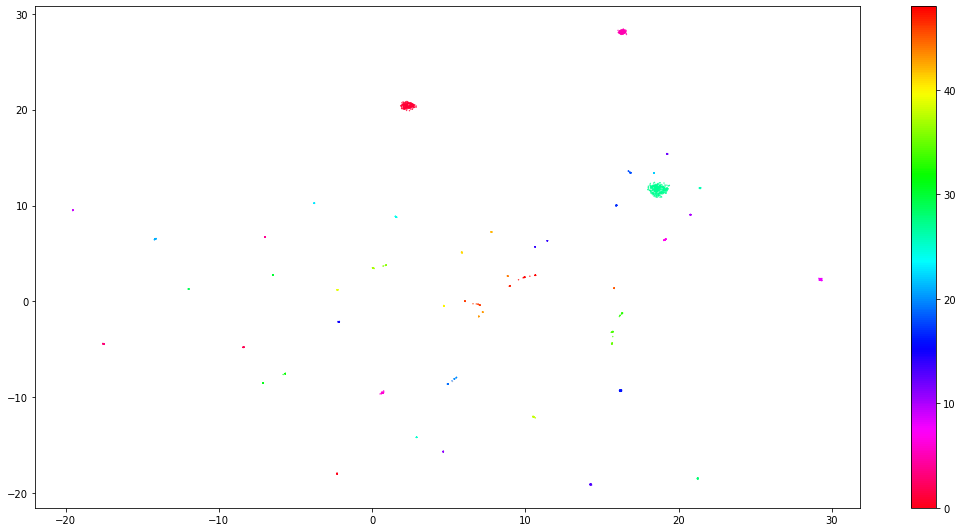

In [163]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(X)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [164]:
docs_df = pd.DataFrame(text, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [165]:
with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]
stopwords[:5]

['ad', 'af', 'aldrig', 'alene', 'alle']

In [176]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(2, 3)):
    count = CountVectorizer(tokenizer = tweet_tokenizer, stop_words = stopwords, ngram_range = (2,4), max_features = 1000, min_df=15, max_df = 0.8).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['.', 'a', 'bl', 'ca', 'f.eks', 'pga'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [177]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
28,27,401
2,1,255
6,5,155
9,8,71
17,16,60
7,6,58
8,7,43
22,21,42
4,3,38
27,26,33


In [178]:
len(top_n_words)
top_n_words[1]

[('#dkpol url', 4.638090323618511),
 ('url #dkpol', 0.3044267348267893),
 ('url url', 0.0),
 ('? #dkpol', 0.0),
 ('. #dkpol', 0.0),
 ('#dkpol #dkmedier', 0.0)]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(8):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. T

In [ ]:
# Get topic ids of alle clusters with more than 200 documents
topic_subset = topic_sizes[topic_sizes.Doc > 200]
topic_subset = list(topic_subset.Topic.values)

In [ ]:
cluster_embeddings = {cluster_id: {} for cluster_id in set(cluster.labels_)}
for idx, clu in enumerate(cluster.labels_):
  if clu == -1:
    continue
  cluster_embeddings[clu][idx]=embeddings[idx, :].tolist()

NameError: ignored

In [ ]:
avg_embeddings = {}
for idx, embs in cluster_embeddings.items():
  #avg_embeddings[idx] = np.mean(np.array(embs), axis = 0)
  v = np.mean(np.array([val for val in embs.values()]), axis = 0)
  normalized_v = v / np.sqrt(np.sum(v**2))
  avg_embeddings[idx] = normalized_v

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
topic_subset

NameError: ignored

In [ ]:
from sentence_transformers.util import semantic_search
import torch

for cluster_id in topic_subset:
  avg_emb = torch.tensor(avg_embeddings[cluster_id])
  documents = torch.tensor(np.array([val for val in cluster_embeddings[cluster_id].values()]))
  print(documents.size())
  exit()
  top_similar = semantic_search(avg_emb, documents, top_k = 5)
  print(top_similar)

NameError: ignored